In [1]:
# Header

In [2]:
# Data Cleaning


import numpy as np
import pandas as pd

# final columns we keep for modeling
KEEP_COLS = [
    "Team","Season","Wins","PointDiff","FG%","3P%","FT%","3PAr","FTr","eFG%","TS%",
    "REB","OREB%","DREB%","AST/TOV","TOV%","ORtg","DRtg","NetRtg","PACE"
]

def safe_div(n, d):
    n = np.asarray(n, dtype="float64")
    d = np.asarray(d, dtype="float64")
    with np.errstate(divide="ignore", invalid="ignore"):
        out = n / d
    out[~np.isfinite(out)] = np.nan
    return out

# 2019-10-22 to most recent in file

def _parse_game_date(df: pd.DataFrame) -> pd.Series:
    """Try multiple date parsing patterns to handle inconsistent formats."""
    s = df["gameDate"].astype(str).str.strip()

    # try ISO or YYYY-MM-DD HH:MM:SS
    dt = pd.to_datetime(s, errors="coerce", utc=True)

    # fill NaTs by trying MM/DD/YYYY and similar US-style formats
    mask = dt.isna()
    if mask.any():
        dt2 = pd.to_datetime(s[mask], format="%m/%d/%Y %I:%M %p", errors="coerce", utc=True)
        dt.loc[mask] = dt2

    # try fallback parse
    mask = dt.isna()
    if mask.any():
        dt3 = pd.to_datetime(s[mask], errors="coerce", utc=True, infer_datetime_format=True)
        dt.loc[mask] = dt3

    return dt


def _label_nba_season(dt: pd.Series) -> pd.Series:
    # July 1 boundary: months < 7 to previous start year
    y = dt.dt.year
    m = dt.dt.month
    start_year = y.where(m >= 7, y - 1)
    return (start_year.astype(int).astype(str) + "-" +
            ((start_year + 1) % 100).astype(str).str.zfill(2))

def filter_past_games(df: pd.DataFrame, start_str: str = "2019-10-22") -> pd.DataFrame:
    d = df.copy()
    d.columns = d.columns.str.strip()
    if "gameDate" not in d.columns:
        raise KeyError("Expected 'gameDate' column in TeamStatistics CSV.")
    d["game_dt"] = _parse_game_date(d)
    start = pd.Timestamp(start_str, tz="UTC")
    end = d["game_dt"].max()  # most recent in THIS file
    d = d.loc[d["game_dt"].between(start, end)].copy()
    return d

def aggregate_team_season(past_filtered: pd.DataFrame) -> pd.DataFrame:
    d = past_filtered.copy()

    # season label 
    d["Season"] = _label_nba_season(d["game_dt"])

    # normalize team column
    team_col = "teamName" if "teamName" in d.columns else ("Team" if "Team" in d.columns else None)
    if not team_col:
        raise KeyError("Could not find a team column (expected 'teamName' or 'Team').")
    d = d.rename(columns={team_col: "Team"})

    # possessions (team side)
    d["_poss"] = (
        pd.to_numeric(d.get("fieldGoalsAttempted"), errors="coerce")
        - pd.to_numeric(d.get("reboundsOffensive"), errors="coerce")
        + pd.to_numeric(d.get("turnovers"), errors="coerce")
        + 0.44 * pd.to_numeric(d.get("freeThrowsAttempted"), errors="coerce")
    )

    # numeric aliases
    d["_pts"] = pd.to_numeric(d.get("teamScore"), errors="coerce")
    d["_opp"] = pd.to_numeric(d.get("opponentScore"), errors="coerce")
    d["_fga"] = pd.to_numeric(d.get("fieldGoalsAttempted"), errors="coerce")
    d["_fgm"] = pd.to_numeric(d.get("fieldGoalsMade"), errors="coerce")
    d["_3pa"] = pd.to_numeric(d.get("threePointersAttempted"), errors="coerce")
    d["_3pm"] = pd.to_numeric(d.get("threePointersMade"), errors="coerce")
    d["_fta"] = pd.to_numeric(d.get("freeThrowsAttempted"), errors="coerce")
    d["_or"]  = pd.to_numeric(d.get("reboundsOffensive"), errors="coerce")
    d["_dr"]  = pd.to_numeric(d.get("reboundsDefensive"), errors="coerce")
    d["_reb"] = pd.to_numeric(d.get("reboundsTotal"), errors="coerce")
    d["_ast"] = pd.to_numeric(d.get("assists"), errors="coerce")
    d["_tov"] = pd.to_numeric(d.get("turnovers"), errors="coerce")

    # optional source columns
    has_ft_pct = "freeThrowsPercentage" in d.columns
    has_wins   = "seasonWins" in d.columns

    # aggregate to Team × Season
    agg_dict = {
        "_pts":"mean","_opp":"mean","_fga":"mean","_fgm":"mean","_3pa":"mean","_3pm":"mean","_fta":"mean",
        "_or":"mean","_dr":"mean","_reb":"mean","_ast":"mean","_tov":"mean","_poss":"mean"
    }
    if has_ft_pct:
        agg_dict["freeThrowsPercentage"] = "mean"
    if has_wins:
        agg_dict["seasonWins"] = "max"

    agg = d.groupby(["Team","Season"]).agg(agg_dict).reset_index()

    # standardize names
    if has_ft_pct:
        agg = agg.rename(columns={"freeThrowsPercentage":"FT_pct_src"})
    else:
        agg["FT_pct_src"] = np.nan
    if has_wins:
        agg = agg.rename(columns={"seasonWins":"Wins"})
    else:
        agg["Wins"] = np.nan

    # feature engineering
    agg["PointDiff"] = agg["_pts"] - agg["_opp"]
    agg["FG%"]  = safe_div(agg["_fgm"], agg["_fga"]) * 100
    agg["3P%"]  = safe_div(agg["_3pm"], agg["_3pa"]) * 100
    agg["FT%"]  = pd.to_numeric(agg["FT_pct_src"], errors="coerce")
    agg["3PAr"] = safe_div(agg["_3pa"], agg["_fga"])
    agg["FTr"]  = safe_div(agg["_fta"], agg["_fga"])
    agg["eFG%"] = safe_div(agg["_fgm"] + 0.5*agg["_3pm"], agg["_fga"])
    agg["TS%"]  = safe_div(agg["_pts"], 2*(agg["_fga"] + 0.44*agg["_fta"]))
    agg["REB"]   = agg["_reb"]
    agg["OREB%"] = safe_div(agg["_or"], agg["_reb"])
    agg["DREB%"] = safe_div(agg["_dr"], agg["_reb"])
    agg["AST/TOV"] = safe_div(agg["_ast"], agg["_tov"])
    agg["TOV%"]    = safe_div(agg["_tov"], agg["_poss"])
    agg["ORtg"]   = safe_div(agg["_pts"], agg["_poss"]) * 100
    agg["DRtg"]   = safe_div(agg["_opp"], agg["_poss"]) * 100
    agg["NetRtg"] = agg["ORtg"] - agg["DRtg"]
    agg["PACE"]   = agg["_poss"]

    out = agg[KEEP_COLS].sort_values(["Season","Team"]).reset_index(drop=True)
    return out

# 2025–26 CSV to same columns

def _norm_header(s: str) -> str:
    return s.replace("\n", " ").strip()

def build_current_features(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.columns = [_norm_header(c) for c in d.columns]
    d = d.rename(columns={c: c.lower() for c in d.columns})

    if "team" not in d.columns:
        # attempt a few alternatives
        for cand in ["teamname","team_name","TEAM","Team"]:
            if cand in df.columns:
                d["team"] = df[cand]
                break
        else:
            raise KeyError("Expected a TEAM column in the 2025–26 CSV ('team' or similar).")

    # common aliases
    if "fg" in d.columns and "fgm" not in d.columns: d = d.rename(columns={"fg":"fgm"})
    if "3p" in d.columns and "3pm" not in d.columns: d = d.rename(columns={"3p":"3pm"})

    # possessions if possible
    if all(c in d.columns for c in ["fga","or","to","fta"]):
        d["_poss"] = d["fga"] - d["or"] + d["to"] + 0.44 * d["fta"]
    else:
        d["_poss"] = np.nan

    mean_cols = [c for c in [
        "pts","oeff","deff","pace","or","dr","tot","a","st","to","bl",
        "fga","fgm","3pa","3pm","fta","ft%","_poss"
    ] if c in d.columns]

    curr = d.groupby("team")[mean_cols].mean(numeric_only=True).reset_index().rename(columns={"team":"Team"})
    curr["Season"] = "2025-26"

    # variable features
    curr["FG%"]  = safe_div(curr.get("fgm", np.nan), curr.get("fga", np.nan)) * 100
    curr["3P%"]  = safe_div(curr.get("3pm", np.nan), curr.get("3pa", np.nan)) * 100
    curr["3PAr"] = safe_div(curr.get("3pa", np.nan), curr.get("fga", np.nan))
    curr["FTr"]  = safe_div(curr.get("fta", np.nan), curr.get("fga", np.nan))
    curr["eFG%"] = safe_div(curr.get("fgm", np.nan) + 0.5*curr.get("3pm", np.nan), curr.get("fga", np.nan))
    if all(c in curr.columns for c in ["pts","fga","fta"]):
        curr["TS%"] = safe_div(curr["pts"], 2*(curr["fga"] + 0.44*curr["fta"]))
    else:
        curr["TS%"] = np.nan

    curr["REB"]   = curr.get("tot", np.nan)
    curr["OREB%"] = safe_div(curr.get("or", np.nan), curr["REB"])
    curr["DREB%"] = safe_div(curr.get("dr", np.nan), curr["REB"])
    curr["AST/TOV"] = safe_div(curr.get("a", np.nan), curr.get("to", np.nan))
    curr["TOV%"]    = safe_div(curr.get("to", np.nan), curr.get("_poss", np.nan))

    curr["ORtg"]   = curr["oeff"] if "oeff" in curr.columns else safe_div(curr.get("pts", np.nan), curr.get("_poss", np.nan)) * 100
    curr["DRtg"]   = curr["deff"] if "deff" in curr.columns else np.nan
    curr["NetRtg"] = curr["ORtg"] - curr["DRtg"]
    curr["PACE"]   = curr["pace"] if "pace" in curr.columns else curr.get("_poss", np.nan)

    # current file won't have reliable season Wins / PointDiff
    curr["FT%"]       = curr["ft%"] if "ft%" in curr.columns else np.nan
    curr["PointDiff"] = np.nan
    curr["Wins"]      = np.nan

    out = curr[KEEP_COLS].sort_values("Team").reset_index(drop=True)
    return out

# merge datasets

def merge_all(past_data, curr_data) -> pd.DataFrame:
    """
    1) Filter TeamStatistics to 2019-10-22 to most-recent date present
    2) Aggregate to Team × Season features.
    3) Build 2025–26 features from the current-season CSV
    4) Concatenate: keep past seasons up to last completed season, and use
       the current-season rows only from the current file (avoid duplicates)
    """
    # build pieces
    past_filtered = filter_past_games(past_data)
    past_features = aggregate_team_season(past_filtered)
    curr_features = build_current_features(curr_data)  # Season == "2025-26"

    # drop the current season from the past piece to avoid double-counting
    last_dt = past_filtered["game_dt"].max()
    last_season_year = last_dt.year if last_dt.month >= 7 else last_dt.year - 1
    last_season_label = f"{last_season_year}-{str((last_season_year + 1) % 100).zfill(2)}"

    past_no_current = past_features[past_features["Season"] != last_season_label]

    # merge the two parts
    df = pd.concat([past_no_current, curr_features], ignore_index=True)

    # final tidy
    df["Team"] = df["Team"].astype(str).str.strip()
    df["Season"] = df["Season"].astype(str)

    # enforce a single row per Team×Season
    num_cols = df.select_dtypes(include="number").columns.tolist()
    agg_dict = {c: "mean" for c in num_cols}
    
    # keep the first occurrence for non-numerics
    agg_dict.update({"Team": "first", "Season": "first"})

    df = (
        df.groupby(["Team", "Season"], as_index=False)
          .agg(agg_dict)
          .reindex(columns=KEEP_COLS)
          .sort_values(["Season", "Team"])
          .reset_index(drop=True)
    )

    return df

In [3]:
# Initialize `final` 
import pandas as pd

data1 = pd.read_csv("https://raw.githubusercontent.com/rheanibert04/Group1-STA4724/refs/heads/main/TeamStatistics%20copy.csv")
data2 = pd.read_csv("https://raw.githubusercontent.com/rheanibert04/Group1-STA4724/refs/heads/main/nba-25%3A26%20copy.csv")

In [4]:
# build merge dataset
final = merge_all(data1, data2)

# quick sanity checks
print(final["Season"].value_counts().sort_index())
print(final.groupby("Season")["Team"].nunique().sort_index())
final.head()





Season
2019-20    30
2020-21    30
2021-22    30
2022-23    30
2023-24    30
2024-25    30
2025-26    30
Name: count, dtype: int64
Season
2019-20    30
2020-21    30
2021-22    30
2022-23    30
2023-24    30
2024-25    30
2025-26    30
Name: Team, dtype: int64


/var/folders/zz/hf6r7jz11fz9mxt9h_4m9knh0000gn/T/ipykernel_93086/1872695601.py:39: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt3 = pd.to_datetime(s[mask], errors="coerce", utc=True, infer_datetime_format=True)


,Team,Season,Wins,PointDiff,FG%,3P%,FT%,3PAr,FTr,eFG%,TS%,REB,OREB%,DREB%,AST/TOV,TOV%,ORtg,DRtg,NetRtg,PACE
0,76ers,2019-20,NaN,2.215385,46.500614,36.159844,0.745631,0.359937,0.251710,0.530082,0.562425,45.461538,0.227750,0.772250,1.822319,0.140222,108.212810,106.025158,2.187652,101.267692
1,Bucks,2019-20,NaN,11.292308,47.739541,35.577689,0.737769,0.423414,0.263495,0.552716,0.582893,51.723077,0.183522,0.816478,1.738906,0.139079,110.688820,100.153862,10.534958,107.188923
2,Bulls,2019-20,NaN,-3.076923,44.654634,34.750219,0.751892,0.396043,0.231170,0.515359,0.547016,41.861538,0.249908,0.750092,1.502488,0.150605,104.074880,107.071997,-2.997117,102.662769
3,Cavaliers,2019-20,NaN,-7.892308,45.826772,35.120773,0.757400,0.362205,0.226772,0.521872,0.552724,44.246154,0.244784,0.755216,1.397950,0.161251,104.414629,112.123999,-7.709370,102.372923
4,Celtics,2019-20,NaN,6.171875,45.928509,36.255708,0.802875,0.381866,0.254752,0.528509,0.566963,45.968750,0.232155,0.767845,1.671249,0.132920,110.112305,104.098151,6.014154,102.622500


In [5]:
# save dataset
final.to_csv("../data/final_csv.csv", index=False)
print("Saved ../data/final_csv.csv")



Saved ../data/final_csv.csv


In [6]:
# Data cleaning break down
"""
Importing and Exploring the Raw Data

    Loaded two datasets:

    TeamStatistics.csv → contains team-level game data (2019–2025)

    nba-25:26.csv → contains current 2025–26 season data

    Checked structure and columns using df.info() and df.head()

    Verified date range, missing values, and column names

Filtering Relevant Seasons

    Extracted all games from October 22, 2019 up to the most recent game in the dataset

    Used pd.to_datetime() to convert game dates to proper datetime format

    Created a new Season column (e.g., “2019–20”, “2020–21”) based on NBA’s July 1 season boundary

Cleaning & Standardizing Columns

    Stripped extra spaces and fixed inconsistent column names (e.g., "teamName" → "Team", "seasonWins" → "Wins")

    Converted numeric columns to proper data types using pd.to_numeric()

    Removed unnecessary text characters and null values (NaNs)

Creating Key Statistical Variables
    Computed advanced metrics used in modeling:

    Field Goal % (FG%) = FGM / FGA

    3-Point % (3P%) = 3PM / 3PA

    Free Throw % (FT%) = FTM / FTA

    Effective FG% (eFG%) = (FGM + 0.5×3PM) / FGA

    True Shooting % (TS%) = PTS / (2 × (FGA + 0.44×FTA))

    Turnover % (TOV%), Assist/Turnover ratio (AST/TOV)

    Offensive & Defensive Ratings (ORtg, DRtg) and Net Rating

Aggregating by Team and Season

    Grouped by Team and Season using groupby()

    Computed per-game averages and totals for all major stats

    Created one clean row per team per season

Merging Historical + Current Data

    Combined past seasons with the 2025–26 data using pd.concat()

    Dropped duplicate rows for the current season to prevent double counting

    Exported final cleaned file as final_csv.csv to /data/

Final Dataset Overview

    Covers 2019–20 through 2025–26 seasons

    Includes 20+ cleaned, numeric variables

    Ready for Exploratory Data Analysis (EDA) and modeling
"""

'\nImporting and Exploring the Raw Data\n\n    Loaded two datasets:\n\n    TeamStatistics.csv → contains team-level game data (2019–2025)\n\n    nba-25:26.csv → contains current 2025–26 season data\n\n    Checked structure and columns using df.info() and df.head()\n\n    Verified date range, missing values, and column names\n\nFiltering Relevant Seasons\n\n    Extracted all games from October 22, 2019 up to the most recent game in the dataset\n\n    Used pd.to_datetime() to convert game dates to proper datetime format\n\n    Created a new Season column (e.g., “2019–20”, “2020–21”) based on NBA’s July 1 season boundary\n\nCleaning & Standardizing Columns\n\n    Stripped extra spaces and fixed inconsistent column names (e.g., "teamName" → "Team", "seasonWins" → "Wins")\n\n    Converted numeric columns to proper data types using pd.to_numeric()\n\n    Removed unnecessary text characters and null values (NaNs)\n\nCreating Key Statistical Variables\n    Computed advanced metrics used in mod

In [7]:
# Basic EDA

In [8]:
# summary

final.select_dtypes(include="number").describe().T

final.drop(columns=["PointDiff", "NetRtg", "ORtg", "DRtg"], inplace=True)

In [9]:
# quick overview
final.info()
final.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Team     210 non-null    object 
 1   Season   210 non-null    object 
 2   Wins     30 non-null     float64
 3   FG%      210 non-null    float64
 4   3P%      210 non-null    float64
 5   FT%      180 non-null    float64
 6   3PAr     210 non-null    float64
 7   FTr      210 non-null    float64
 8   eFG%     210 non-null    float64
 9   TS%      210 non-null    float64
 10  REB      210 non-null    float64
 11  OREB%    210 non-null    float64
 12  DREB%    210 non-null    float64
 13  AST/TOV  210 non-null    float64
 14  TOV%     210 non-null    float64
 15  PACE     210 non-null    float64
dtypes: float64(14), object(2)
memory usage: 26.4+ KB


,Team,Season,Wins,FG%,3P%,FT%,3PAr,FTr,eFG%,TS%,REB,OREB%,DREB%,AST/TOV,TOV%,PACE
0,76ers,2019-20,NaN,46.500614,36.159844,0.745631,0.359937,0.251710,0.530082,0.562425,45.461538,0.227750,0.772250,1.822319,0.140222,101.267692
1,Bucks,2019-20,NaN,47.739541,35.577689,0.737769,0.423414,0.263495,0.552716,0.582893,51.723077,0.183522,0.816478,1.738906,0.139079,107.188923
2,Bulls,2019-20,NaN,44.654634,34.750219,0.751892,0.396043,0.231170,0.515359,0.547016,41.861538,0.249908,0.750092,1.502488,0.150605,102.662769
3,Cavaliers,2019-20,NaN,45.826772,35.120773,0.757400,0.362205,0.226772,0.521872,0.552724,44.246154,0.244784,0.755216,1.397950,0.161251,102.372923
4,Celtics,2019-20,NaN,45.928509,36.255708,0.802875,0.381866,0.254752,0.528509,0.566963,45.968750,0.232155,0.767845,1.671249,0.132920,102.622500
5,Clippers,2019-20,NaN,46.419237,36.646255,0.793000,0.369925,0.292560,0.531974,0.573964,47.953125,0.228413,0.771587,1.613108,0.140716,105.043125
6,Grizzlies,2019-20,NaN,46.998140,35.165924,0.759508,0.341451,0.234061,0.530019,0.561258,46.707692,0.223650,0.776350,1.771169,0.145136,105.153231
7,Hawks,2019-20,NaN,44.882149,33.319536,0.788358,0.398220,0.258118,0.515164,0.554171,43.253731,0.228088,0.771912,1.477901,0.151232,107.179701
8,Heat,2019-20,NaN,46.955888,38.322296,0.774354,0.412869,0.297667,0.548669,0.587475,44.538462,0.190674,0.809326,1.744835,0.146212,101.854154
9,Hornets,2019-20,NaN,43.412102,35.186015,0.748646,0.399391,0.251701,0.504386,0.538871,42.784615,0.257102,0.742898,1.632244,0.147391,99.056000


In [10]:
# numeric summary
num_desc = final.select_dtypes(include="number").describe().T
num_desc


,count,mean,std,min,25%,50%,75%,max
Wins,30.0,41.000000,13.354581,17.000000,34.500000,40.500000,50.000000,68.000000
FG%,210.0,46.575519,1.824618,40.384615,45.626161,46.615426,47.571146,52.661064
3P%,210.0,35.866773,1.902450,27.906977,34.696545,36.009192,36.967215,42.207792
FT%,180.0,0.776791,0.025337,0.696879,0.759440,0.775671,0.794182,0.842243
3PAr,210.0,0.399842,0.042095,0.311107,0.367920,0.393638,0.425542,0.530331
FTr,210.0,0.259969,0.031134,0.199881,0.241725,0.253228,0.270418,0.406312
eFG%,210.0,0.537503,0.021002,0.453297,0.526471,0.536947,0.551551,0.599548
TS%,210.0,0.572979,0.020542,0.500626,0.561101,0.573543,0.585058,0.643180
REB,210.0,44.134462,2.290866,36.000000,42.807692,44.000000,45.431969,51.723077
OREB%,210.0,0.239248,0.030004,0.183522,0.220501,0.233028,0.254248,0.349693


In [11]:
# check for missing values
final.isna().sum().sort_values(ascending=False)

# some missing games due to current active season

Wins       180
FT%         30
Team         0
Season       0
FG%          0
3P%          0
3PAr         0
FTr          0
eFG%         0
TS%          0
REB          0
OREB%        0
DREB%        0
AST/TOV      0
TOV%         0
PACE         0
dtype: int64

In [12]:
# numeric correlation 
num = final.select_dtypes(include="number")
corr_with_wins = num.corr().loc[:, "Wins"].sort_values(ascending=False)
corr_with_wins


Wins       1.000000
TS%        0.715010
eFG%       0.704456
AST/TOV    0.673658
FG%        0.654741
3P%        0.607086
REB        0.234796
FT%        0.229213
DREB%      0.215462
FTr        0.111789
3PAr       0.036374
PACE      -0.112159
OREB%     -0.217858
TOV%      -0.721677
Name: Wins, dtype: float64

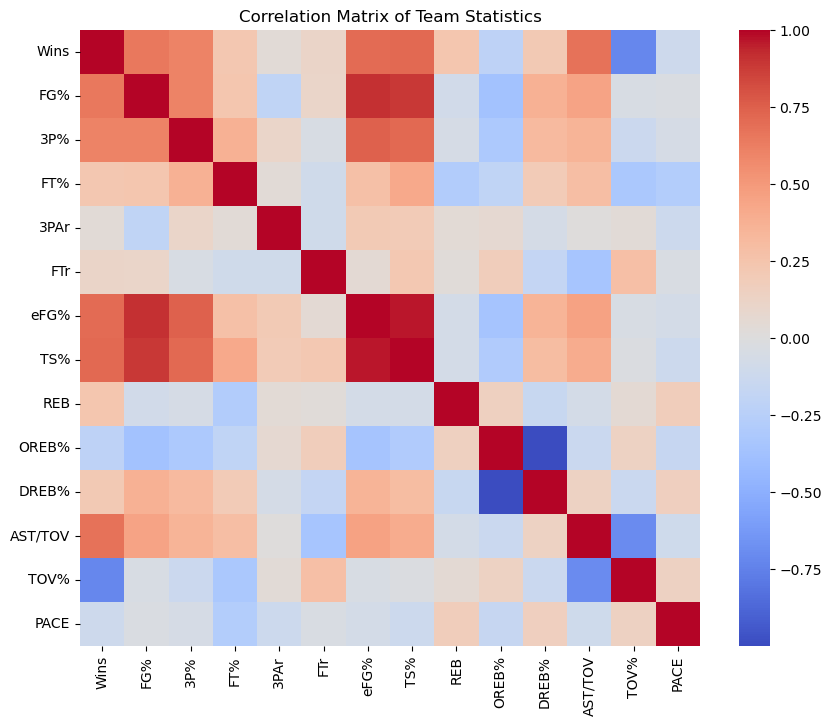

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = final.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Team Statistics")

# save image
# plt.savefig("../reports/corr_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


In [14]:
# using a baseline multiple linear regression model to see how much does each stat contribute to a win
# Cell 1 — baseline linear regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Prepare data
model_data = final.dropna(subset=["Wins"]).copy()
X = model_data.drop(columns=["Wins", "Team", "Season"])
y = model_data["Wins"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train & evaluate
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Coefficients (feature influence)
coef = pd.Series(lr.coef_, index=X.columns).sort_values(ascending=False)
coef


R²: -0.2777597027538208
MAE: 8.788502514130718


3PAr        3520.824750
TS%          691.338849
FG%          195.225424
FTr          114.269978
3P%           38.314256
AST/TOV       21.245035
REB            4.765511
PACE          -2.366606
FT%         -122.327981
TOV%        -477.147529
DREB%      -3292.937511
OREB%      -3313.613912
eFG%      -19663.928064
dtype: float64

In [15]:
# ridge regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5)
)
ridge.fit(X_train, y_train)

y_pred_r = ridge.predict(X_test)

print("R²:", r2_score(y_test, y_pred_r))
print("MAE:", mean_absolute_error(y_test, y_pred_r))

importance = pd.Series(
    ridge.named_steps['ridgecv'].coef_,
    index=X.columns
).sort_values(ascending=False)
importance


R²: 0.32340432338317826
MAE: 6.694769496607196


REB        7.197296
FTr        4.215097
AST/TOV    3.640939
TS%        1.568195
FG%        1.491780
FT%        1.140992
eFG%       1.102208
3PAr       0.404569
DREB%     -0.332338
OREB%     -0.405079
3P%       -0.464536
PACE      -3.169899
TOV%      -5.538666
dtype: float64

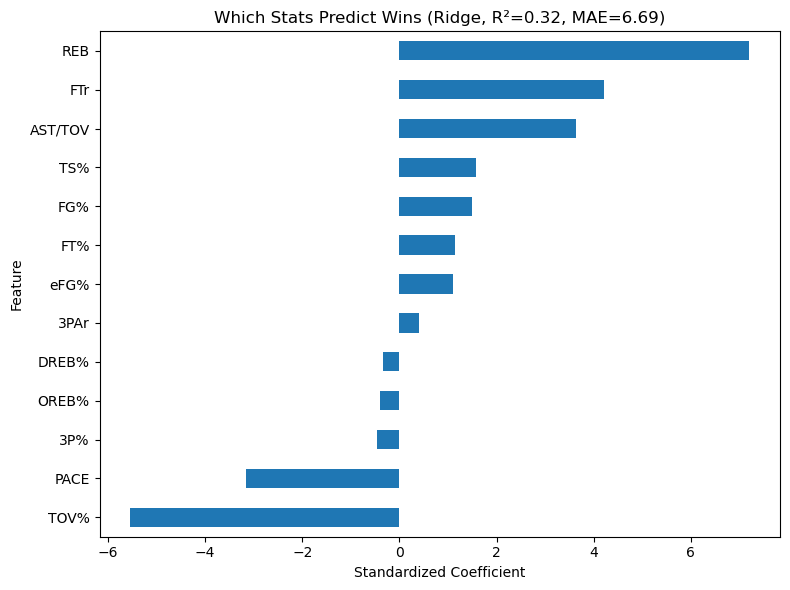

In [16]:
# feature importance (RidgeCV + scaling)
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error

# load the merged data (or re-use `final` if it's already in memory)
# final = pd.read_csv("../data/final_csv.csv")

# training set = completed seasons only
model_df = final.dropna(subset=["Wins"]).copy()
X = model_df.drop(columns=["Wins","Team","Season"])
y = model_df["Wins"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5))
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# standardized coefficients (comparable importance)
imp = pd.Series(ridge.named_steps["ridgecv"].coef_, index=X.columns).sort_values()

plt.figure(figsize=(8,6))
imp.plot(kind="barh")
plt.xlabel("Standardized Coefficient")
plt.ylabel("Feature")
plt.title(f"Which Stats Predict Wins (Ridge, R²={r2:.2f}, MAE={mae:.2f})")
plt.tight_layout()

# save image
# plt.savefig("../reports/feature_importance_ridge.png", dpi=150)
plt.show()

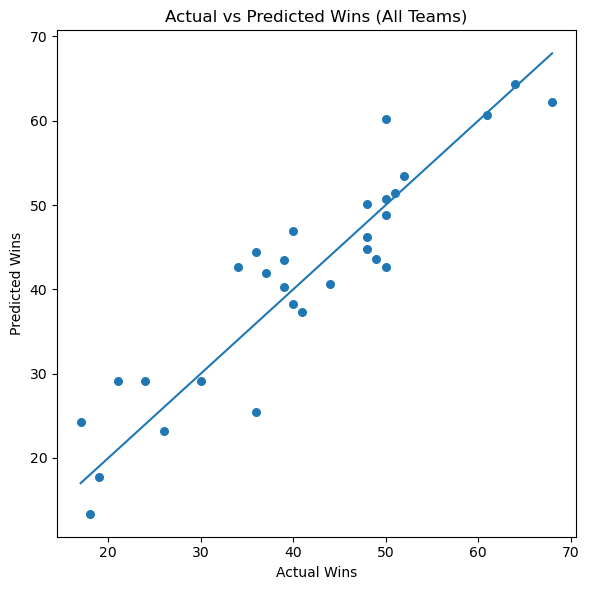

In [17]:
# Actual vs Predicted wins
import matplotlib.pyplot as plt
import numpy as np

# visualize how the model performs across the entire dataset
y_all_pred = ridge.predict(X)
plt.figure(figsize=(6,6))
plt.scatter(y, y_all_pred, s=30)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel("Actual Wins")
plt.ylabel("Predicted Wins")
plt.title("Actual vs Predicted Wins (All Teams)")
plt.tight_layout()
plt.show()


# save image
# plt.savefig("../reports/pred_vs_actual_ridge.png", dpi=150)
plt.show()


In [18]:
# Next Steps
""""
Descriptive - describe(), histograms, means
Correlation - heatmap, corr with Wins
Relationships - scatterplots, trend lines
Season Trend - groupby season, lineplots
Modeling - R², MAE, coefficient ranking
Visuals - importance bar chart, actual vs predicted
Extras - PCA, clustering, residual plots
Decision Tree to capture nonlinearity
"""

'"\nDescriptive - describe(), histograms, means\nCorrelation - heatmap, corr with Wins\nRelationships - scatterplots, trend lines\nSeason Trend - groupby season, lineplots\nModeling - R², MAE, coefficient ranking\nVisuals - importance bar chart, actual vs predicted\nExtras - PCA, clustering, residual plots\nDecision Tree to capture nonlinearity\n'